# PROJECT PHASE 1
## GROUP 1 (AMAZON FASHION)

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt

## Data Exploration

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3176 entries, 0 to 3175
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         3176 non-null   float64
 1   verified        3176 non-null   bool   
 2   reviewTime      3176 non-null   object 
 3   reviewerID      3176 non-null   object 
 4   asin            3176 non-null   object 
 5   style           3107 non-null   object 
 6   reviewerName    3176 non-null   object 
 7   reviewText      3160 non-null   object 
 8   summary         3176 non-null   object 
 9   unixReviewTime  3176 non-null   int64  
 10  vote            297 non-null    object 
 11  image           106 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 276.2+ KB
None
   overall  verified  reviewTime     reviewerID        asin  \
0      5.0      True  09 4, 2015  ALJ66O1Y6SLHA  B000K2PJ4K   
1      5.0      True  09 4, 2015  ALJ66O1Y6SLHA  B000K2PJ4K

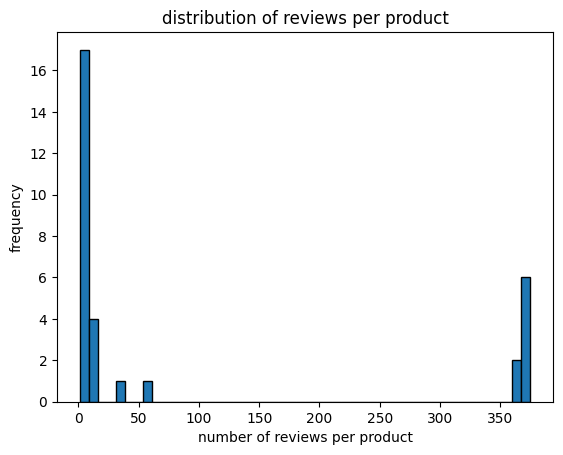

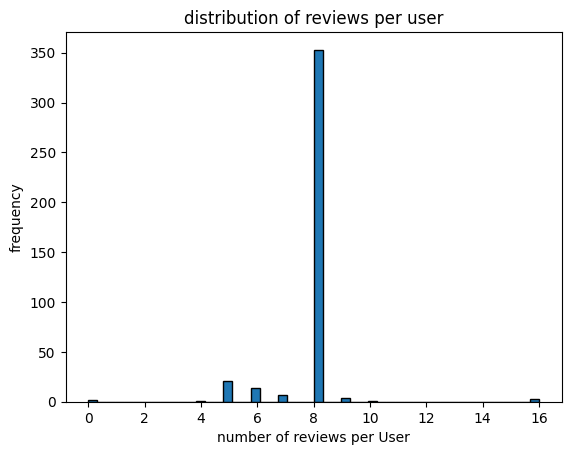

average review length (words): 24.71
max review length: 272
min review length: 0


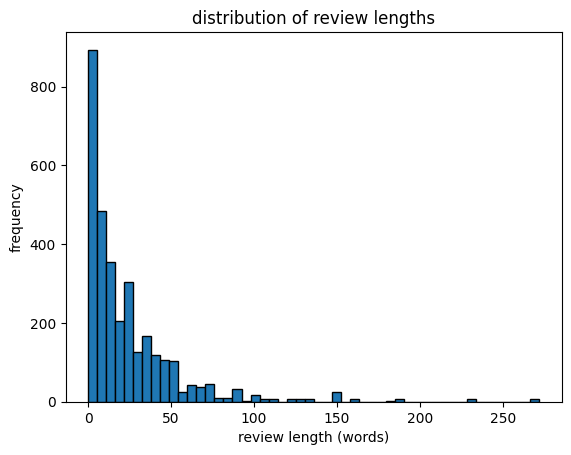

initial dataset size: 3176
number of duplicate reviews: 167
dataset size after removing duplicates: 3087


In [2]:

# DELIVERABLE 1)
# Function to load line-delimited JSON
def load_json_lines(path):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"error decoding json at line {len(data)}: {e}")
    return pd.DataFrame(data)

# Load the dataset
file_path = "AMAZON_FASHION_5.json"
df = load_json_lines(file_path)

# Show basic dataset info
print(df.info())
print(df.head())

# Basic statistics
print(f"total reviews: {len(df)}")
print(f"total unique products: {df['asin'].nunique()}")
print(f"total unique users: {df['reviewerID'].nunique()}")
print(f"average rating: {df['overall'].mean():.2f}")
print(df['overall'].value_counts(normalize=True) * 100)

# Distribution of reviews per product
reviews_per_product = df.groupby("asin")["reviewText"].count()
plt.hist(reviews_per_product, bins=50, edgecolor="black")
plt.xlabel("number of reviews per product")
plt.ylabel("frequency")
plt.title("distribution of reviews per product")
plt.show()

# Distribution of reviews per user
reviews_per_user = df.groupby("reviewerID")["reviewText"].count()
plt.hist(reviews_per_user, bins=50, edgecolor="black")
plt.xlabel("number of reviews per User")
plt.ylabel("frequency")
plt.title("distribution of reviews per user")
plt.show()

# Review length analysis
df["review_length"] = df["reviewText"].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
print(f"average review length (words): {df['review_length'].mean():.2f}")
print(f"max review length: {df['review_length'].max()}")
print(f"min review length: {df['review_length'].min()}")
plt.hist(df["review_length"], bins=50, edgecolor="black")
plt.xlabel("review length (words)")
plt.ylabel("frequency")
plt.title("distribution of review lengths")
plt.show()

# Checking and dropping duplicates
print(f"initial dataset size: {len(df)}")
duplicates = df[df.duplicated(subset=["reviewText", "reviewerID", "asin", "unixReviewTime"], keep=False)]
print(f"number of duplicate reviews: {len(duplicates)}")
df = df.drop_duplicates(subset=["reviewText", "reviewerID", "asin", "unixReviewTime"], keep="first")
print(f"dataset size after removing duplicates: {len(df)}")


## Text Pre-processing

In [3]:
# Step 2a: Labeling the sentiment

def label_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

df["sentiment"] = df["overall"].apply(label_sentiment)
print(df['sentiment'].value_counts())

# Remove missing reviewText entries
df['reviewText'] = df['reviewText'].fillna("").astype(str)

sentiment
Positive    2570
Neutral      322
Negative     195
Name: count, dtype: int64


In [4]:
# Step 2b: Selecting columns for sentiment analysis
selected_columns = ["reviewText", "summary", "sentiment"]
df = df[selected_columns]

# Justification:
# - 'reviewText': Main body of the review, containing the most valuable sentiment information.
# - 'summary': Short version of the review, often useful for reinforcement of sentiment.
# - 'sentiment': The labeled target variable for sentiment analysis. (only needed if labels will be used)
# 'asin' (Product ID) and 'reviewerID' (User ID) could be useful in some cases, to track sentiment trends per product or user. may not be necessary for a basic sentiment analysis.

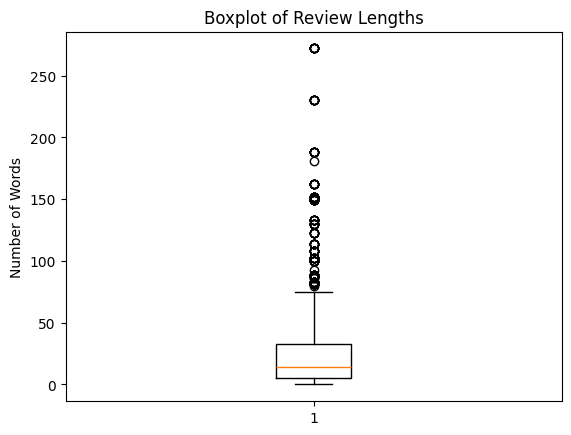

Sample of reviews that are too short (length 0):
    reviewText
172           
285           
535           
648           
890           

Sample of reviews that are too long:
                                            reviewText
13   Pinnacle seems to have more cushioning so my h...
20   Pinnacle seems to have more cushioning so my h...
167  Great shoe. I've had Nike's before and have al...
204  Very good overall.\nNow Ive been a huge Sketch...
208  Glad I read the reviews and ordered a half siz...

Number of reviews that are too short (length 0): 16
Number of reviews that are too long: 163


In [5]:
# Step 2c: Checking for outliers in review length

review_lengths = df["reviewText"].apply(lambda x: len(str(x).split()))

# Boxplot of Review Lengths
plt.boxplot(review_lengths)
plt.title("Boxplot of Review Lengths")
plt.ylabel("Number of Words")
plt.show()

# Identifying extreme outliers
q1 = review_lengths.quantile(0.25)
q3 = review_lengths.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Reviews that are too short (length 0 or below)
too_short = df[review_lengths == 0]

# Reviews that are too long (greater than upper bound)
too_long = df[review_lengths > upper_bound]

# Printing samples of too short and too long reviews
print("Sample of reviews that are too short (length 0):")
print(too_short[["reviewText"]].head())

print("\nSample of reviews that are too long:")
print(too_long[["reviewText"]].head())

# Print number of reviews that are too short and too long
print(f"\nNumber of reviews that are too short (length 0): {len(too_short)}")
print(f"Number of reviews that are too long: {len(too_long)}")

## Pre-processing

In [6]:
import seaborn as sns
import html
import contractions

In [7]:
# Remove empty reviews

before_empty_removal = len(df)
df = df[df["reviewText"].notna() & (df["reviewText"] != "")]
print(f"\nNumber of rows before removing empty reviews: {before_empty_removal}")
print(f"Number of rows after removing empty reviews: {len(df)}")


Number of rows before removing empty reviews: 3087
Number of rows after removing empty reviews: 3071


In [8]:
# Pre-processing for VADER

print("\nSample of 'reviewText' before VADER preprocessing:")
print(df["reviewText"].head(3))  # Print first 3 rows
df["reviewText"] = df["reviewText"].str.lower()  # Lowercase
df["reviewText"] = df["reviewText"].apply(
    lambda x: html.unescape(x)
)  # Decode HTML entities
# Emojis and punctuation are retained by default; no additional steps needed
print("\nSample of 'reviewText' after VADER preprocessing:")
print(df["reviewText"].head(3))


Sample of 'reviewText' before VADER preprocessing:
0                         Great product and price!
5    Waaay too small. Will use for futur children!
6                  Stays vibrant after many washes
Name: reviewText, dtype: object

Sample of 'reviewText' after VADER preprocessing:
0                         great product and price!
5    waaay too small. will use for futur children!
6                  stays vibrant after many washes
Name: reviewText, dtype: object


In [9]:
# Pre-processing for TextBlob

print("\nSample of 'reviewText' before TextBlob preprocessing:")
print(df["reviewText"].head(3))  # Print first 3 rows
df["reviewText"] = df["reviewText"].str.lower()  # Lowercase
df["reviewText"] = df["reviewText"].str.replace(
    r"[^\w\s]", "", regex=True
)  # Remove special characters
df["reviewText"] = df["reviewText"].apply(
    lambda x: contractions.fix(x)
)  # Expand contractions
print("\nSample of 'reviewText' after TextBlob preprocessing:")
print(df["reviewText"].head(3))


Sample of 'reviewText' before TextBlob preprocessing:
0                         great product and price!
5    waaay too small. will use for futur children!
6                  stays vibrant after many washes
Name: reviewText, dtype: object

Sample of 'reviewText' after TextBlob preprocessing:
0                        great product and price
5    waaay too small will use for futur children
6                stays vibrant after many washes
Name: reviewText, dtype: object



Review length IQR: 28.0
Lower bound: -37.0, Upper bound: 75.0
Number of rows before removing outliers: 3071
Number of rows after removing outliers: 2908
Sampled dataset size: 1000


/tmp/ipykernel_4555/972829780.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(review_lengths > 0) & (review_lengths <= upper_bound)]


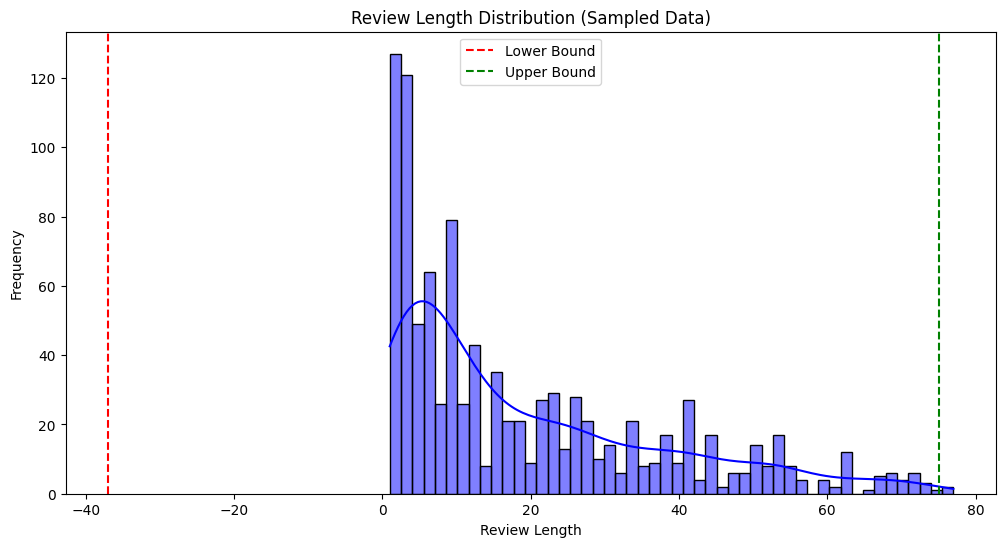

In [10]:
# Remove outliers
print(f"\nReview length IQR: {iqr}")
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
before_outlier_removal = len(df)
df = df[(review_lengths > 0) & (review_lengths <= upper_bound)]
print(f"Number of rows before removing outliers: {before_outlier_removal}")
print(f"Number of rows after removing outliers: {len(df)}")

# Randomly select 1000 reviews from the cleaned dataset
if len(df) >= 1000:
    df = df.sample(n=1000, random_state=42)
else:
    df = df.copy()
print(f"Sampled dataset size: {len(df)}")

# Recompute the review_length column in case it's missing
df["review_length"] = df["reviewText"].apply(lambda x: len(str(x).split()))

# Visualize review lengths for the sampled data
plt.figure(figsize=(12, 6))
sns.histplot(df["review_length"], bins=50, kde=True, color="blue")
plt.axvline(lower_bound, color="red", linestyle="--", label="Lower Bound")
plt.axvline(upper_bound, color="green", linestyle="--", label="Upper Bound")
plt.title("Review Length Distribution (Sampled Data)")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## Model Building

In [11]:
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from sklearn.metrics import classification_report

In [12]:
# Downloading necessary resources
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/sgidy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [13]:
# Generating sentiment labels from 'overall' ratings

df['reviewText'] = df['reviewText'].fillna("").astype(str)


# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    """Classifies sentiment using VADER"""
    if not isinstance(text, str):
        text = ""
    score = sia.polarity_scores(text)
    return "Positive" if score['compound'] > 0 else "Negative" if score['compound'] < 0 else "Neutral"

def textblob_sentiment(text):
    """Classifies sentiment using TextBlob"""
    if not isinstance(text, str):
        text = ""
    score = TextBlob(text).sentiment.polarity
    return "Positive" if score > 0 else "Negative" if score < 0 else "Neutral"


In [14]:
# Applying sentiment analysis

df['VADER_Sentiment'] = df['reviewText'].apply(vader_sentiment)
df['TextBlob_Sentiment'] = df['reviewText'].apply(textblob_sentiment)

In [15]:
# Model performance comparison

print("VADER Sentiment Analysis Report:")
print(classification_report(df['sentiment'], df['VADER_Sentiment']))

print("TextBlob Sentiment Analysis Report:")
print(classification_report(df['sentiment'], df['TextBlob_Sentiment']))

VADER Sentiment Analysis Report:
              precision    recall  f1-score   support

    Negative       0.47      0.47      0.47        57
     Neutral       0.16      0.11      0.13       103
    Positive       0.89      0.93      0.91       840

    accuracy                           0.82      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.79      0.82      0.80      1000

TextBlob Sentiment Analysis Report:
              precision    recall  f1-score   support

    Negative       0.45      0.53      0.49        57
     Neutral       0.07      0.04      0.05       103
    Positive       0.88      0.93      0.90       840

    accuracy                           0.81      1000
   macro avg       0.47      0.50      0.48      1000
weighted avg       0.78      0.81      0.79      1000



In [16]:
# Saving the results to CSV
df.to_csv("sentiment_analysis_results.csv", index=False)
print("Results saved to sentiment_analysis_results.csv")

Results saved to sentiment_analysis_results.csv


In [17]:
# Model Evaluation and Comparison

report_vader = classification_report(df['sentiment'], df['VADER_Sentiment'], output_dict=True)
report_textblob = classification_report(df['sentiment'], df['TextBlob_Sentiment'], output_dict=True)

# Build evaluation results dictionary using macro average metrics and overall accuracy
evaluation_results = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "VADER": [
        report_vader["accuracy"],
        report_vader["macro avg"]["precision"],
        report_vader["macro avg"]["recall"],
        report_vader["macro avg"]["f1-score"],
    ],
    "TextBlob": [
        report_textblob["accuracy"],
        report_textblob["macro avg"]["precision"],
        report_textblob["macro avg"]["recall"],
        report_textblob["macro avg"]["f1-score"],
    ]
}

df_eval = pd.DataFrame(evaluation_results)
print(df_eval)

# Saving the CSV files
df_eval.to_csv(
    "model_comparison.csv",
    index=False,
)

      Metric     VADER  TextBlob
0   Accuracy  0.816000  0.812000
1  Precision  0.504954  0.470903
2     Recall  0.502224  0.497114
3   F1-Score  0.501870  0.481137


<Figure size 800x500 with 0 Axes>

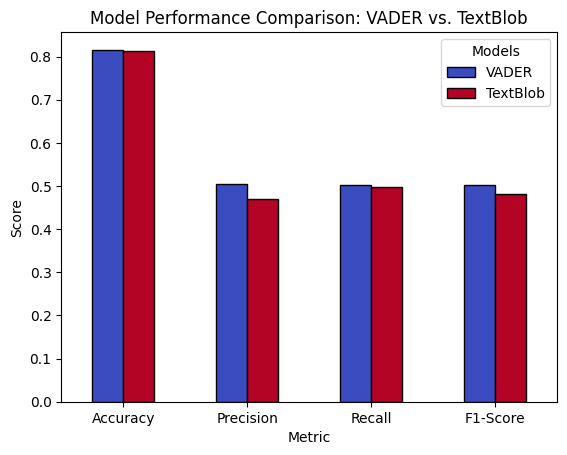

In [18]:
# Visualizing Model Performance

plt.figure(figsize=(8, 5))
df_eval.set_index("Metric").plot(kind="bar", colormap="coolwarm", edgecolor="black")
plt.title("Model Performance Comparison: VADER vs. TextBlob")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Models")
plt.show()